By: Rutendo F. Sigauke


# Summary

- Here, counts for genes and bidirectionals from all samples are normalized as shown: 

    1. Gene counts for the longest isoform were counted in a sense strand manner.
    
    2. The lengths from the truncated annotations were used in the TPM calculation. 
    
    3. If a bidirectional transcript overlapped the truncated gene annotation, the opposite sense reads were assigned to the bidirectional. 
    
        - If a bidirectional transcript overlapped a sense and antisense transcript, it was removed from the normalization. (see: https://github.com/Dowell-Lab/bidirectionals_merged)
    
        - Overlap was performed with human transcripts from curated RefSeq genes (NM, NR, NP). A total of 42,224 transcripts from 28,889 genes.
        
        - The bedtools overlap fraction was set to `-f 0.975`.
    
    4. For intergenic bidirectionals, reads from both strands were used. 

- The normalization was performed such that bidirectional and gene transcripts were combined in a single table.

- Further more, 1645 human samples were filter as follows:

    1. Keep samples with `sample QC` 1 and 2
    
    2. Keep GRO-seq and PRO-seq samples
    
    3. Removed samples with low GC content in the bidirectional calls (< 0.49)


# Load libraries

In [1]:
library(ggplot2) ##plotting package
library(cowplot) ##plots + arrange plots etc
library(data.table) ##fast loading of large tables
library(dplyr) ## for the R pipes
library(tidyr) ## for tidying the dataframes
library(RColorBrewer) ## color palettes


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions for processing 

## TPM

In [2]:
tpm_calculation <- function(count_g,len_g) {
    
    #' calculate tpms for counts #https://support.bioconductor.org/p/91218/
    #' 
    #' @description This function will calculate tpms for counts table
    #' derived from the same library.  
    #' 
    #' @param count_g data.frame. first counts
    #' 
    #' @param len_g list of integers. Transcript lengths corresponding to count_g
    #' 
    #'
    #' @usage tpm(count_g, len_g)
    #' @return Matix with tpms values for genes as a data.frame
    #' @export

    #get length normalized counts
    g <- count_g/len_g

    #get sum of length normalized counts
    tot_tpms <- colSums(g)

    #calculate the TPMs
    tpm_g <- t(t(g)*1e6/tot_tpms)

    return(tpm_g)   
  
}

## CV

In [3]:
cv <- function(x){
    #' calculate coefficient of variation for set of values
    #' 
    #' @description This function will calculate coefficient of variation
    #' 
    #' @param x list of values
    #' 
    #' @usage cv(x)
    #' @return CV value
    #' @export
    
    #sd(x, na.rm=TRUE)/mean(x, na.rm=TRUE)
    sd(x, na.rm=FALSE)/mean(x, na.rm=FALSE)
}

## Summary statistics

In [4]:
get_summary_statistics <- function(counts_df, genenames, bidirnames){
    
    #1. transcript lenths
    transcript_lengths <- (counts_df$stop - counts_df$start) +1

    #2. number of columns in the dataframes
    ncolumns <- ncol(counts_df)

    
    ##get summary statistics for bed6+counts data.frame
    #3. transcript coordinated in bed6 format
    df_summary <- counts_df[,1:6]

    #4. get stats like length, st.dev, etc
    df_summary$length <- transcript_lengths
    df_summary$stdev <- apply(counts_df[c(7:ncolumns)], 1, sd)
    df_summary$variance <- apply(counts_df[c(7:ncolumns)], 1, var)
    df_summary$sum <- apply(counts_df[c(7:ncolumns)], 1, sum)
    df_summary$mean <- apply(counts_df[c(7:ncolumns)], 1, mean)
    df_summary$median <- apply(counts_df[c(7:ncolumns)], 1, median)
    df_summary$coefvar <- apply(counts_df[c(7:ncolumns)], 1, cv)
    df_summary$max <- apply(counts_df[c(7:ncolumns)], 1, max)
    df_summary$min <- apply(counts_df[c(7:ncolumns)], 1, min)
    df_summary$num_transcribed <- rowSums(counts_df[c(7:ncolumns)] != 0)
    df_summary$percent_transcribed <- (df_summary$num_transcribed/(ncolumns-6))*100
    df_summary$transcript_type <- ifelse(df_summary$gene_transcript %in% genenames,
                                                 "genes",
                                                 ifelse(df_summary$gene_transcript %in% bidirnames,
                                                        "bidirectional","NA"))
    return(df_summary)
    
}

## PCA calculation on TPMS

1. Log transform counts
2. Calculate euclidean distances between samples
3. Perform PCA on transformed data

In [5]:
pca_counts <- function(tpm_bed_df, ncols, constant=0.0000001, pca_rank=4){
    
    # log transform tpms after a constant is added to all counts
    tpm_matrix_log <- log(as.matrix(tpm_bed_df[,7:ncols]+constant))
    nsamples <- ncol(tpm_matrix_log)
    
    # transpose matrix
    tpm_matrix_log_transpose <- t(tpm_matrix_log)
    
    # calculate distance using distances::distances() is faster than dist(), see link below
    ##https://stackoverflow.com/questions/68931399/fast-way-to-compute-distance-matrix-in-r-for-large-matrix
    tpm_log_dist <- distances::distances(tpm_matrix_log_transpose)
    
    # get distance matrix
    tpm_log_dist_matrix <- distances::distance_matrix(tpm_log_dist)
    
    #PCA with all samples
    pca_samples <- prcomp(tpm_log_dist_matrix , rank = pca_rank)
    
    eigs_matrix <- matrix(0, ncol = pca_rank, nrow = nsamples)
    eigs <- pca_samples$sdev^2

    for (i in 1:pca_rank){
    
        print(paste("Principal Component : ", i))
        pc_var <- round((eigs[i] / sum(eigs))*100, digits = 2)
        print(paste("Explained variance = ", pc_var))
    
        eigs_matrix[,i] <- pca_samples$x[,i]
    }
    
    pc_ranks <- paste0("PC",1:pca_rank) #get column names for the PCs
    eigs_df <- as.data.frame(eigs_matrix) #convert the matrix to data.frame
    colnames(eigs_df) <- pc_ranks #assign PC column names
    eigs_df$sample_name <- colnames(tpm_matrix_log) #add sample names
    
    return(eigs_df)
}

## PCA plot with custom colours

In [6]:
gg_pca <- function(df,pc_a, pc_b,col_by,
                   palette, title, xlable,ylable, legendlab ){
    #' Generate PCA plot
    #' 
    #' @description This function will return PCA plot 
    #' 
    #' @param df data.frame with PC values
    #' @param pc_a string of PC to plot on the x axis
    #' @param pc_b string of PC to plot on the y axis
    #' @param col_by string representing how to group the colors
    #' @param palette string string of color palette to use
    #' @param title string of the plot title
    #' @param xlable string
    #' @param ylable string
    #' @param lagendlab string
    #' 
    #' @usage gg_pca(df,pc_a, pc_b,col_by,
    #'               palette, title, xlable,ylable, legendlab )
    #' @return PCA plot
    #' @export
    
    ggplot(df, aes(pc_a, pc_b, fill=col_by)) +
    ylab(ylable) + xlab(xlable) + ggtitle(title) +
    geom_point(size=5,shape=21,color="gray40") + theme_bw() +
    scale_fill_brewer(name = legendlab,palette=palette)+
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.background = element_rect(colour = "black", size=0.75))+
    theme(plot.title = element_text(hjust = 0.5),
          title = element_text(size = 24, face = "bold"), 
          axis.title = element_text(size = 20,face = "bold"), 
          axis.text = element_text(size = 18),
         legend.title = element_text(size = 18),
     legend.text = element_text(size = 16))
    
}

## PCA plot with color palette

In [7]:
gg_pca_palette  <- function(df,pc_a, pc_b,col_by,
                   palette, title, xlable,ylable, legendlab ){
    #' Generate PCA plot
    #' 
    #' @description This function will return PCA plot 
    #' 
    #' @param df data.frame with PC values
    #' @param pc_a string of PC to plot on the x axis
    #' @param pc_b string of PC to plot on the y axis
    #' @param col_by string representing how to group the colors
    #' @param palette string string of color palette to use
    #' @param title string of the plot title
    #' @param xlable string
    #' @param ylable string
    #' @param lagendlab string
    #' 
    #' @usage gg_pca(df,pc_a, pc_b,col_by,
    #'               palette, title, xlable,ylable, legendlab )
    #' @return PCA plot
    #' @export
    
    ggplot(df, aes(pc_a, pc_b, fill=col_by)) +
    ylab(ylable) + xlab(xlable) + ggtitle(title) +
    geom_point(size=5,shape=21,color="gray40") + theme_bw() +
    scale_fill_manual(name = legendlab,values=palette)+
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.background = element_rect(colour = "black", size=0.75))+
    theme(plot.title = element_text(hjust = 0.5),
          title = element_text(size = 24, face = "bold"), 
          axis.title = element_text(size = 20,face = "bold"), 
          axis.text = element_text(size = 18),
         legend.title = element_text(size = 18),
     legend.text = element_text(size = 16))
    
}

# Import data 

## Metadata

In [8]:
##previous metadata was from /Users/rusi2317/projects/bidir_mumerge/condition_setup/20211026_db_output.csv
metadata <- data.table::fread("/Users/rusi2317/projects/DBNascent-build/230131_db_output.tsv")
dim(metadata)
head(metadata)

[1] 2880   14

organism,tissue,tissue_description,disease,srp,paper_id,protocol,sample_name,sample_type,cell_type,samp_qc_score,samp_data_score,replicate,control_experimental
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
A. thaliana,seed,seed,0,SRP076266,Hetzel2016nascent,GRO-cap,SRR3647033,tissue,seed,3,1,1,control
A. thaliana,seed,seed,0,SRP076266,Hetzel2016nascent,GRO-seq,SRR3647034,tissue,seed,4,1,1,control
A. thaliana,seed,seed,0,SRP076266,Hetzel2016nascent,GRO-seq,SRR3647035,tissue,seed,3,1,2,control
A. thaliana,seedling,seedling,0,SRP101403,Liu2018arabidopsis,GRO-seq,SRR5313794,tissue,seedling,5,1,1,experimental
A. thaliana,seedling,seedling,0,SRP101403,Liu2018arabidopsis,GRO-seq,SRR5313795,tissue,seedling,4,1,2,experimental
A. thaliana,seedling,seedling,0,SRP101403,Liu2018arabidopsis,GRO-seq,SRR5313796,tissue,seedling,4,1,1,control


## GC content for bidirectionals

In [9]:
##get paths for the counts tables
bc_files <- list.files(path="/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/processed_data/paper_mumerges/all_calls", 
                              pattern="txt$",full.names=TRUE)
head(bc_files, 3)

[1] "/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/processed_data/paper_mumerges/all_calls/hg38_dreg_gc_content.txt"
[2] "/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/processed_data/paper_mumerges/all_calls/hg38_tfit_gc_content.txt"
[3] "/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/processed_data/paper_mumerges/all_calls/mm10_dreg_gc_content.txt"

In [10]:
bc_list <- lapply(bc_files, data.table::fread)

In [11]:
base_composition <- do.call(rbind, bc_list)
base_composition$bidir_caller <- c(rep('dREG', 188), rep('Tfit', 189), 
                                   rep('dREG', 87), rep('Tfit', 87))
base_composition$sample_name <- substr(base_composition$id,1,nchar(base_composition$id)-5)
dim(base_composition)
head(base_composition, 3)

[1] 551   5

id,cg,at,bidir_caller,sample_name
<chr>,<dbl>,<dbl>,<chr>,<chr>
Heinaniemi2016transcription_hg38_REH_dreg,0.5694224,0.4305776,dREG,Heinaniemi2016transcription_hg38_REH
Oh2021enhancer_hg38_dreg,0.5514242,0.4485758,dREG,Oh2021enhancer_hg38
Nair2019phase_hg38_dreg,0.5411443,0.4588557,dREG,Nair2019phase_hg38


In [12]:
base_composition$bidir_caller <- as.character(lapply(lapply((strsplit(as.character(base_composition$id), 
                                                                        '_')),
                                                                         rev), `[`, 1))
base_composition$sample_name <- substr(base_composition$id,1,nchar(base_composition$id)-5)

##Tfit base compositions
base_composition_tfit <- subset(base_composition, bidir_caller=='tfit')

##dREG base composition
base_composition_dreg <- subset(base_composition, bidir_caller=='dreg')

##base composition Tfit and dREG wide
base_composition_tfit_dreg <- merge(base_composition_tfit, base_composition_dreg, by='sample_name')
base_composition_tfit_dreg$author <- as.character(lapply(strsplit(as.character(base_composition_tfit_dreg$sample_name), '_'), `[`, 1))
colnames(base_composition_tfit_dreg) <- c('sample_name','id_tfit','cg_tfit','at_tfit', 'bidir_caller_tfit',
                                         'id_dreg','cg_dreg','at_dreg', 'bidir_caller_dreg','author')
dim(base_composition_tfit_dreg)
head(base_composition_tfit_dreg)

[1] 275  10

sample_name,id_tfit,cg_tfit,at_tfit,bidir_caller_tfit,id_dreg,cg_dreg,at_dreg,bidir_caller_dreg,author
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Aeby2020decapping_mm10,Aeby2020decapping_mm10_tfit,0.5242389,0.4757611,tfit,Aeby2020decapping_mm10_dreg,0.5315533,0.4684467,dreg,Aeby2020decapping
Agarwal2021kdm1a_mm10_ESC,Agarwal2021kdm1a_mm10_ESC_tfit,0.5252982,0.4747018,tfit,Agarwal2021kdm1a_mm10_ESC_dreg,0.5365821,0.4634179,dreg,Agarwal2021kdm1a
Agarwal2021kdm1a_mm10_cortical_neuron,Agarwal2021kdm1a_mm10_cortical_neuron_tfit,0.5484798,0.4515202,tfit,Agarwal2021kdm1a_mm10_cortical_neuron_dreg,0.5844059,0.4155941,dreg,Agarwal2021kdm1a
Aho2019displacement_hg38,Aho2019displacement_hg38_tfit,0.5272918,0.4727082,tfit,Aho2019displacement_hg38_dreg,0.5540693,0.4459307,dreg,Aho2019displacement
Alexander2019imprinted_mm10_liver,Alexander2019imprinted_mm10_liver_tfit,0.5453144,0.4546856,tfit,Alexander2019imprinted_mm10_liver_dreg,0.5593769,0.4406231,dreg,Alexander2019imprinted
Alexander2019imprinted_mm10_yolk_sac,Alexander2019imprinted_mm10_yolk_sac_tfit,0.5335900,0.4664100,tfit,Alexander2019imprinted_mm10_yolk_sac_dreg,0.5424324,0.4575676,dreg,Alexander2019imprinted


In [13]:
tfit_dreg_low_gc <- subset(base_composition_tfit_dreg,
                                  as.numeric(cg_tfit) < 0.49 &
                                  as.numeric(cg_dreg) < 0.49 )

tfit_dreg_low_gc

sample_name,id_tfit,cg_tfit,at_tfit,bidir_caller_tfit,id_dreg,cg_dreg,at_dreg,bidir_caller_dreg,author
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Franco2015tnfalpha_hg38,Franco2015tnfalpha_hg38_tfit,0.4370900,0.5629100,tfit,Franco2015tnfalpha_hg38_dreg,0.4551700,0.5448300,dreg,Franco2015tnfalpha
Franco2018enhancer_hg38_HCC1954,Franco2018enhancer_hg38_HCC1954_tfit,0.4687915,0.5312085,tfit,Franco2018enhancer_hg38_HCC1954_dreg,0.4795275,0.5204725,dreg,Franco2018enhancer
Franco2018enhancer_hg38_MCF7,Franco2018enhancer_hg38_MCF7_tfit,0.4538106,0.5461894,tfit,Franco2018enhancer_hg38_MCF7_dreg,0.4639019,0.5360981,dreg,Franco2018enhancer
Franco2018enhancer_hg38_MDA-MB-231,Franco2018enhancer_hg38_MDA-MB-231_tfit,0.4479029,0.5520971,tfit,Franco2018enhancer_hg38_MDA-MB-231_dreg,0.4565119,0.5434881,dreg,Franco2018enhancer
Franco2018enhancer_hg38_UACC812,Franco2018enhancer_hg38_UACC812_tfit,0.4656669,0.5343331,tfit,Franco2018enhancer_hg38_UACC812_dreg,0.4734330,0.5265670,dreg,Franco2018enhancer
Salony2016akt_hg38_HCT116,Salony2016akt_hg38_HCT116_tfit,0.4029277,0.5970723,tfit,Salony2016akt_hg38_HCT116_dreg,0.3715021,0.6284979,dreg,Salony2016akt
Salony2016akt_hg38_MCF7,Salony2016akt_hg38_MCF7_tfit,0.4156052,0.5843948,tfit,Salony2016akt_hg38_MCF7_dreg,0.3718583,0.6281417,dreg,Salony2016akt
Saponaro2014recql5_hg38,Saponaro2014recql5_hg38_tfit,0.4557303,0.5442697,tfit,Saponaro2014recql5_hg38_dreg,0.4838420,0.5161580,dreg,Saponaro2014recql5
Veloso2013genome-wide_hg38_skin_fibroblast,Veloso2013genome-wide_hg38_skin_fibroblast_tfit,0.4739904,0.5260096,tfit,Veloso2013genome-wide_hg38_skin_fibroblast_dreg,0.4887963,0.5112037,dreg,Veloso2013genome-wide


## Counts

### Genes

- `5' Truncated gene annotations`

In [14]:
counts_genes <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/genes/counts_filt_5ptrunc_gene_stranded_counts.txt',
                                 sep='\t')
dim(counts_genes)
head(counts_genes)

[1] 28889  1651

chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,14361,28620,WASH7P:NR_024540.1,.,-,43,4,45,34,⋯,12,10,38,30,42,62,53,44,49,61
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,34610,35591,FAM138A:NR_026818.1,.,-,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,66168,71585,OR4F5:NM_001005484.2,.,+,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Bidirectional counts

In [15]:
counts_neg_bidirs <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/bidirectionals/counts_bidirectionals_neg.bed',
                                  sep='\t')
counts_neg_bidirs$bidirs <- paste0(counts_neg_bidirs$chrom,':',
                              counts_neg_bidirs$start,'-',
                              counts_neg_bidirs$end)
dim(counts_neg_bidirs)
head(counts_neg_bidirs, 3)

[1] 847521   1651

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3917,4919,chr1:3917-4919,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,5632,6042,chr1:5632-6042,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,6132,6486,chr1:6132-6486,7,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [16]:
counts_pos_bidirs <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/bidirectionals/counts_bidirectionals_pos.bed',
                                  sep='\t')
counts_pos_bidirs$bidirs <- paste0(counts_pos_bidirs$chrom,':',
                              counts_pos_bidirs$start,'-',
                              counts_pos_bidirs$end)
dim(counts_pos_bidirs)
head(counts_pos_bidirs, 3)

[1] 847521   1651

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3917,4919,chr1:3917-4919,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,5632,6042,chr1:5632-6042,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,6132,6486,chr1:6132-6486,7,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [17]:
nsamples <- as.numeric(ncol(counts_pos_bidirs))

counts_bidirs <- cbind(counts_pos_bidirs[,1:6],
                       counts_pos_bidirs[,7:nsamples] + counts_neg_bidirs[,7:nsamples])
dim(counts_bidirs)
head(counts_bidirs, 3)

[1] 847521   1651

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3917,4919,chr1:3917-4919,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,5632,6042,chr1:5632-6042,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,6132,6486,chr1:6132-6486,7,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Bidirectional transcripts not in genes

- Get bidirectional transcripts not overlapping genes

The gene list used to filter out bidirectionals was for the high confidence curated RefSeq genes (NM, NR, NP). This returned a list with 42224 transcripts from 28889 genes.


```sh
#!/bin/bash

#SBATCH --job-name=bidir_overlapping_refseq
#SBATCH --output=/scratch/Users/rusi2317/e_and_o/%x_%j.out
#SBATCH --error=/scratch/Users/rusi2317/e_and_o/%x_%j.err
#SBATCH --time=00:05:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem=10MB
#SBATCH --partition short
#SBATCH --mail-type=FAIL
#SBATCH --mail-user=rutendo.sigauke@colorado.edu

module purge
module load bedtools/2.28.0

###########################
##0: initialize files    ## 
###########################
hg38_refseq=/scratch/Shares/dowell/genomes/hg38/ncbi/hg38_refseq_diff53prime_with_putatives.bed #hg38_refseq_diff53prime_with_putatives_5ptrunc.bed ##truncated gene coodinates 
hg38_bidirs=/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/bidirectionals_dreg_tfit/hg38_tfit_dreg_bidirectionals.bed
outdir=/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations
mkdir -p ${outdir}

########################################################################
#1: get bidirectionals NOT overlapping RefSeq truncated genes         ##
########################################################################
#get bidirectional transcripts NOT overlapping RefSeq
#filter RefSeq annotations so that only the curated gene list is used (NM,NR,NP)
cat ${hg38_refseq} | grep "NM_\|NR_\|NP_" | bedtools intersect -a ${hg38_bidirs} -b - -f 0.975 -wa -v > ${outdir}/hg38_tfit_dreg_bidirectionals_non_genes.bed

#get those that do overlap, along with the gene annotations
#filter RefSeq annotations so that only the curated gene list is used (NM,NR,NP)
cat ${hg38_refseq} | grep "NM_\|NR_\|NP_" | bedtools intersect -a ${hg38_bidirs} -b - -f 0.975 -wa -wb > ${outdir}/hg38_tfit_dreg_bidirectionals_in_genes.bed ##was 0.5
```  

#### Bidirectionals `NOT` overlapping genes

In [18]:
bidir_anno_non_genes <- data.table::fread('/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations/hg38_tfit_dreg_bidirectionals_non_genes.bed',
                                  sep='\t')
colnames(bidir_anno_non_genes) <- c('chrom','start','end','bidirs','score','strand')
bidir_anno_non_genes$bidirs <- paste0(bidir_anno_non_genes$chrom,':',
                                     bidir_anno_non_genes$start,'-',
                                     bidir_anno_non_genes$end)
dim(bidir_anno_non_genes)
head(bidir_anno_non_genes, 3)

[1] 352645      6

chrom,start,end,bidirs,score,strand
<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,3917,4919,chr1:3917-4919,14,.
chr1,5632,6042,chr1:5632-6042,14,.
chr1,6132,6486,chr1:6132-6486,7,.


In [19]:
print("Percent of bidirectionals not overlapping genes.")
print("Requiring >= 97.5% of the bidirectional overlaps gene annotations.(-f 0.975)")
(nrow(bidir_anno_non_genes)/nrow(counts_bidirs))*100

[1] "Percent of bidirectionals not overlapping genes."
[1] "Requiring >= 97.5% of the bidirectional overlaps gene annotations.(-f 0.975)"


[1] 41.609

In [20]:
counts_bidirs_no_genes <- counts_bidirs[counts_bidirs$bidirs %in% bidir_anno_non_genes$bidirs , ] 
dim(counts_bidirs_no_genes)
head(counts_bidirs_no_genes, 3)


[1] 352645   1651

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3917,4919,chr1:3917-4919,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,5632,6042,chr1:5632-6042,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,6132,6486,chr1:6132-6486,7,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


#### Bidirectionals overlapping genes

In [21]:
bidir_anno_genes <- data.table::fread('/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations/hg38_tfit_dreg_bidirectionals_in_genes.bed',
                                     sep='\t')

colnames(bidir_anno_genes) <- c('bidir_chrom','bidir_start','bidir_end',
                                'bidir_id','bidir_score','bidir_strand',
                               'gene_chrom','gene_start','gene_end',
                                'gene_id','gene_score','gene_strand')
bidir_anno_genes$bidirs <- paste0(bidir_anno_genes$bidir_chrom,':',
                                     bidir_anno_genes$bidir_start,'-',
                                     bidir_anno_genes$bidir_end)

print(paste0("Number of overlaps: ",nrow(bidir_anno_genes)))
print(paste0("Unique bidirectionals overlapping: ", length(unique(bidir_anno_genes$bidirs))))
head(bidir_anno_genes, 3)
tail(bidir_anno_genes, 3)


[1] "Number of overlaps: 873393"
[1] "Unique bidirectionals overlapping: 494876"


bidir_chrom,bidir_start,bidir_end,bidir_id,bidir_score,bidir_strand,gene_chrom,gene_start,gene_end,gene_id,gene_score,gene_strand,bidirs
<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
chr1,12182,12456,"tfit,dreg",1,.,chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1:12182-12456
chr1,13264,13506,tfit,14,.,chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1:13264-13506
chr1,14655,14811,"tfit,dreg",14,.,chr1,14361,29370,WASH7P:NR_024540.1,.,-,chr1:14655-14811


bidir_chrom,bidir_start,bidir_end,bidir_id,bidir_score,bidir_strand,gene_chrom,gene_start,gene_end,gene_id,gene_score,gene_strand,bidirs
<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
chrY,25390010,25390360,dreg,1,.,chrY,25378299,25394719,SEPTIN14P23:NR_174182.1,.,-,chrY:25390010-25390360
chrY,25390600,25390950,dreg,3,.,chrY,25378299,25394719,SEPTIN14P23:NR_174182.1,.,-,chrY:25390600-25390950
chrY,25392590,25393000,dreg,2,.,chrY,25378299,25394719,SEPTIN14P23:NR_174182.1,.,-,chrY:25392590-25393000


In [22]:
#subset bidirectionals overllaping the positive and the negative strands
bidir_anno_genes_pos <- subset(bidir_anno_genes, gene_strand=="+")
bidir_anno_genes_neg <- subset(bidir_anno_genes, gene_strand=="-")
nrow(bidir_anno_genes_pos)
nrow(bidir_anno_genes_neg)

[1] 442326

[1] 431067

In [23]:
#get bidirectionals that overlap sense and antisense genes
bidirs_pos_neg <- (unique(intersect(bidir_anno_genes_pos$bidirs, bidir_anno_genes_neg$bidirs)))
length(bidirs_pos_neg) ##There are none in this case since these bidirectionals were filtered out

[1] 0

In [24]:
length(intersect(bidir_anno_genes_pos$bidirs, bidir_anno_genes_neg$bidirs))

[1] 0

In [25]:
##remove any bidirectionals that overlap both senses from the filters
bidir_overlap_genes_pos <- bidir_anno_genes_pos[!bidir_anno_genes_pos$bidirs %in%bidirs_pos_neg,]$bidirs
bidir_overlap_genes_neg <- bidir_anno_genes_neg[!bidir_anno_genes_neg$bidirs %in%bidirs_pos_neg,]$bidirs

In [26]:
##assign opposite sense reads to bidirectionals overlapping a gene
##if a bidirectional overlaps a negative sense gene, assigned the positive sense reads to bidirectional and vise versa
counts_pos_bidirs_inGenes <- counts_pos_bidirs[counts_pos_bidirs$bidirs %in% bidir_overlap_genes_neg,]
counts_neg_bidirs_inGenes <- counts_neg_bidirs[counts_neg_bidirs$bidirs %in% bidir_overlap_genes_pos,]

nrow(counts_pos_bidirs_inGenes)
nrow(counts_neg_bidirs_inGenes)

[1] 243529

[1] 251347

In [27]:
##Check if there is overlap between the bidirectionals
intersect(counts_pos_bidirs_inGenes$bidirs, counts_neg_bidirs_inGenes$bidirs)

character(0)

# Combine Gene `AND` Bidirectional counts

 - Genes + Bidirectionals `INCLUDING` overlapping genes

In [28]:
counts_all_bidir_genes_trunc <- as.data.frame(rbind(counts_genes, 
                                                    counts_bidirs_no_genes,
                                                    counts_pos_bidirs_inGenes,
                                                    counts_neg_bidirs_inGenes,
                                        use.names=FALSE))
dim(counts_all_bidir_genes_trunc)
head(counts_all_bidir_genes_trunc, 3)
tail(counts_all_bidir_genes_trunc, 3)

[1] 876410   1651

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,43,4,45,34,⋯,12,10,38,30,42,62,53,44,49,61
3,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
876408,chrY,24849020,24849850,chrY:24849020-24849850,1,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
876409,chrY,24881508,24881926,chrY:24881508-24881926,2,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
876410,chrY,24903562,24903988,chrY:24903562-24903988,6,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# Normalize counts

- Genes + Bidirectionals `INCLUDING` overlapping genes

In [29]:
##get variables for the TPM calculation function
##and calculate normalized counts

#1. transcript lenths
transcript_lengths_all <- (counts_all_bidir_genes_trunc$stop - counts_all_bidir_genes_trunc$start) +1

#2. number of columns in the dataframes
ncolumns <- ncol(counts_all_bidir_genes_trunc)

#3. get normalized counts by sample
gene_all_bidir_tpms <- tpm_calculation(counts_all_bidir_genes_trunc[,7:ncolumns], 
                        transcript_lengths_all)

#4. merge the transcript annotations with normalized counts data.frame
gene_all_bidir_tpm_df <- cbind(counts_all_bidir_genes_trunc[,1:6],
                           as.data.frame(gene_all_bidir_tpms))

#summary of data.frame
dim(gene_all_bidir_tpm_df)
head(gene_all_bidir_tpm_df)

[1] 876410   1651

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0.0000000,0.00000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,0.1844719,0.03814665,0.1945557,0.1415614,⋯,0.04399975,0.05040534,0.2144871,0.1048455,0.3700028,0.4193475,0.3418568,0.2917163,0.3737646,0.4307619
3,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,0.0000000,0.00000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
4,chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,0.0000000,0.00000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
5,chr1,34610,35591,FAM138A:NR_026818.1,.,-,0.0000000,0.00000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
6,chr1,66168,71585,OR4F5:NM_001005484.2,.,+,0.0000000,0.00000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


# Summary statistics

- The summary statistics were calculated with counts for:
    1. Longest gene isoform
    2. Bidirectional transcripts also overlapping genes

In [30]:
gene_all_bidir_tpm_summary <- get_summary_statistics(gene_all_bidir_tpm_df,
                                                counts_genes$gene_transcript,
                                                counts_bidirs$bidirs)
dim(gene_all_bidir_tpm_summary)
head(gene_all_bidir_tpm_summary)

[1] 876410     18

,chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.139203283,1.937755e-02,27.63320413,1.679830e-02,0.000000,8.286748,2.85400871,0,60,3.64741641,genes
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.296353061,8.782514e-02,360.43669606,2.191105e-01,0.138357,1.352528,3.29492522,0,1499,91.12462006,genes
3,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,69,0.000000000,0.000000e+00,0.00000000,0.000000e+00,0.000000,NaN,0.00000000,0,0,0.00000000,genes
4,chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,139,0.023015503,5.297134e-04,0.93347658,5.674630e-04,0.000000,40.558600,0.93347658,0,1,0.06079027,genes
5,chr1,34610,35591,FAM138A:NR_026818.1,.,-,982,0.001830887,3.352147e-06,0.07425821,4.514177e-05,0.000000,40.558600,0.07425821,0,1,0.06079027,genes
6,chr1,66168,71585,OR4F5:NM_001005484.2,.,+,5418,0.002441340,5.960139e-06,0.31369605,1.906967e-04,0.000000,12.802213,0.06116138,0,16,0.97264438,genes


# Filter samples

## (i) By QC

In [31]:
##Human samples with high QC
hg38_high_qc <- subset(metadata, organism=="H. sapiens" & samp_qc_score<3)
nrow(hg38_high_qc)
head(hg38_high_qc, 3)

[1] 910

organism,tissue,tissue_description,disease,srp,paper_id,protocol,sample_name,sample_type,cell_type,samp_qc_score,samp_data_score,replicate,control_experimental
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266931,cell line,MV4-11,1,2,1,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266932,cell line,MV4-11,2,1,2,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266933,cell line,MV4-11,1,2,1,experimental


In [32]:
unique(hg38_high_qc$protocol)

[1] "PRO-seq"  "GRO-seq"  "other"    "PRO-cap"  "ChRO-seq" "NET-seq"

## (ii) By protocol

In [33]:
hg38_high_qc_gro_pro <- subset(hg38_high_qc, protocol=='PRO-seq' | protocol=='GRO-seq')
nrow(hg38_high_qc_gro_pro)

[1] 779

## (iii) By Tfit and dREG call GC content

In [34]:
hg38_high_qc_gc <- hg38_high_qc_gro_pro[!hg38_high_qc_gro_pro$paper_id %in% tfit_dreg_low_gc$author,]
nrow(hg38_high_qc_gc)


[1] 751

## Filter files

In [35]:
##filter all bidirectional and gene transcripts
gene_all_bidir_tpm_filtered <- cbind(gene_all_bidir_tpm_df[,1:6], gene_all_bidir_tpm_df[,
                                                          colnames(gene_all_bidir_tpm_df)
                                                          %in% hg38_high_qc_gc$sample_name])
dim(gene_all_bidir_tpm_filtered)
head(gene_all_bidir_tpm_filtered, 3)

[1] 876410    757

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713715,SRR3713716,SRR3713717,SRR3713718,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0.0000000,0.00000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,0.1844719,0.03814665,0.1945557,0.1415614,⋯,0.06812888,0.04399975,0.05040534,0.2144871,0.3700028,0.4193475,0.3418568,0.2917163,0.3737646,0.4307619
3,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,0.0000000,0.00000000,0.0000000,0.0000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [37]:
##get summary statistics based on the filtered samples
gene_all_bidir_tpm_filtered_summary <- get_summary_statistics(gene_all_bidir_tpm_filtered,
                                                counts_genes$gene_transcript,
                                                counts_bidirs$bidirs)
dim(gene_all_bidir_tpm_filtered_summary)
head(gene_all_bidir_tpm_filtered_summary)

[1] 876410     18

,chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.072099287,5.198307e-03,6.76054154,9.002053e-03,0.0000000,8.0092052,1.25232307,0,29,3.8615180,genes
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.190457404,3.627402e-02,163.61697071,2.178655e-01,0.1674576,0.8741973,1.58704620,0,749,99.7336884,genes
3,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,69,0.000000000,0.000000e+00,0.00000000,0.000000e+00,0.0000000,NaN,0.00000000,0,0,0.0000000,genes
4,chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,139,0.034063044,1.160291e-03,0.93347658,1.242978e-03,0.0000000,27.4043792,0.93347658,0,1,0.1331558,genes
5,chr1,34610,35591,FAM138A:NR_026818.1,.,-,982,0.002709721,7.342586e-06,0.07425821,9.887911e-05,0.0000000,27.4043792,0.07425821,0,1,0.1331558,genes
6,chr1,66168,71585,OR4F5:NM_001005484.2,.,+,5418,0.002555593,6.531054e-06,0.18860450,2.511378e-04,0.0000000,10.1760572,0.04010044,0,11,1.4647137,genes


In [40]:
##All bidirectionals Filtered samples
data.table::fwrite(gene_all_bidir_tpm_filtered,
                   "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/gene_bidir_tpm_allBidirs_filteredSamples.tsv.gz",
                  sep='\t')
data.table::fwrite(gene_all_bidir_tpm_filtered_summary, 
                   "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/gene_bidir_tpm_summary_allBidirs_filteredSamples.tsv.gz",
                  sep='\t')

In [42]:
head(hg38_high_qc_gc)

organism,tissue,tissue_description,disease,srp,paper_id,protocol,sample_name,sample_type,cell_type,samp_qc_score,samp_data_score,replicate,control_experimental
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266931,cell line,MV4-11,1,2,1,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266932,cell line,MV4-11,2,1,2,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266933,cell line,MV4-11,1,2,1,experimental
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266934,cell line,MV4-11,1,2,2,experimental
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266935,cell line,MV4-11,1,2,1,experimental
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266936,cell line,MV4-11,1,2,2,experimental


In [43]:
data.table::fwrite(hg38_high_qc_gc, 
                   "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/human_samples_QC_GC_protocol_filtered.tsv.gz",
                  sep='\t')

# Exploratory data analysis (EDA)

## PCA

### All samples

The PCA plot shows greater separate on PC1 driven by sample QC score, suggesting we should remove samples with poor QC from downstream analyses.

In [44]:
##1. get all genes
gene_tpm_df <- gene_all_bidir_tpm_df[gene_all_bidir_tpm_df$gene_transcript %in% 
                                 counts_genes$gene_transcript,]

##2. filter genes with transcription
gene_tpm_df_transcribed <- subset(gene_all_bidir_tpm_summary, max >=5)
gene_tpm_transcribed_df <- gene_tpm_df[gene_tpm_df$gene_transcript %in% 
                                       gene_tpm_df_transcribed$gene_transcript, ]

##3. run PCA
pca_genes_bidirs <- pca_counts(gene_tpm_transcribed_df, ncolumns)

[1] "Principal Component :  1"
[1] "Explained variance =  76.47"
[1] "Principal Component :  2"
[1] "Explained variance =  7.88"
[1] "Principal Component :  3"
[1] "Explained variance =  4.02"
[1] "Principal Component :  4"
[1] "Explained variance =  2.47"


In [45]:
pc1 <- "76.47"
pc2 <- "7.88"
pc3 <- "4.02"
pc4 <- "2.47"

In [46]:
##combine PCs with metadata
pc_tpms_metadata <- merge(pca_genes_bidirs, 
                          metadata, 
                         by = 'sample_name')

In [47]:
length(unique(pc_tpms_metadata$tissue))
# Define the number of colors you want
nb.cols2 <- length(unique(pc_tpms_metadata$tissue))
mycolors2 <- colorRampPalette(brewer.pal(8, "Set1"))(nb.cols2)
mycolors2

[1] 19

[1] "#E41A1C" "#A04058" "#5D6795" "#3A86A5" "#43997A" "#4BAC50" "#658E67"
 [8] "#83688A" "#A35390" "#CB6651" "#F37912" "#FFA20E" "#FFD422" "#FAF532"
[15] "#D7B32E" "#B47229" "#B85F49" "#D77084" "#F781BF"

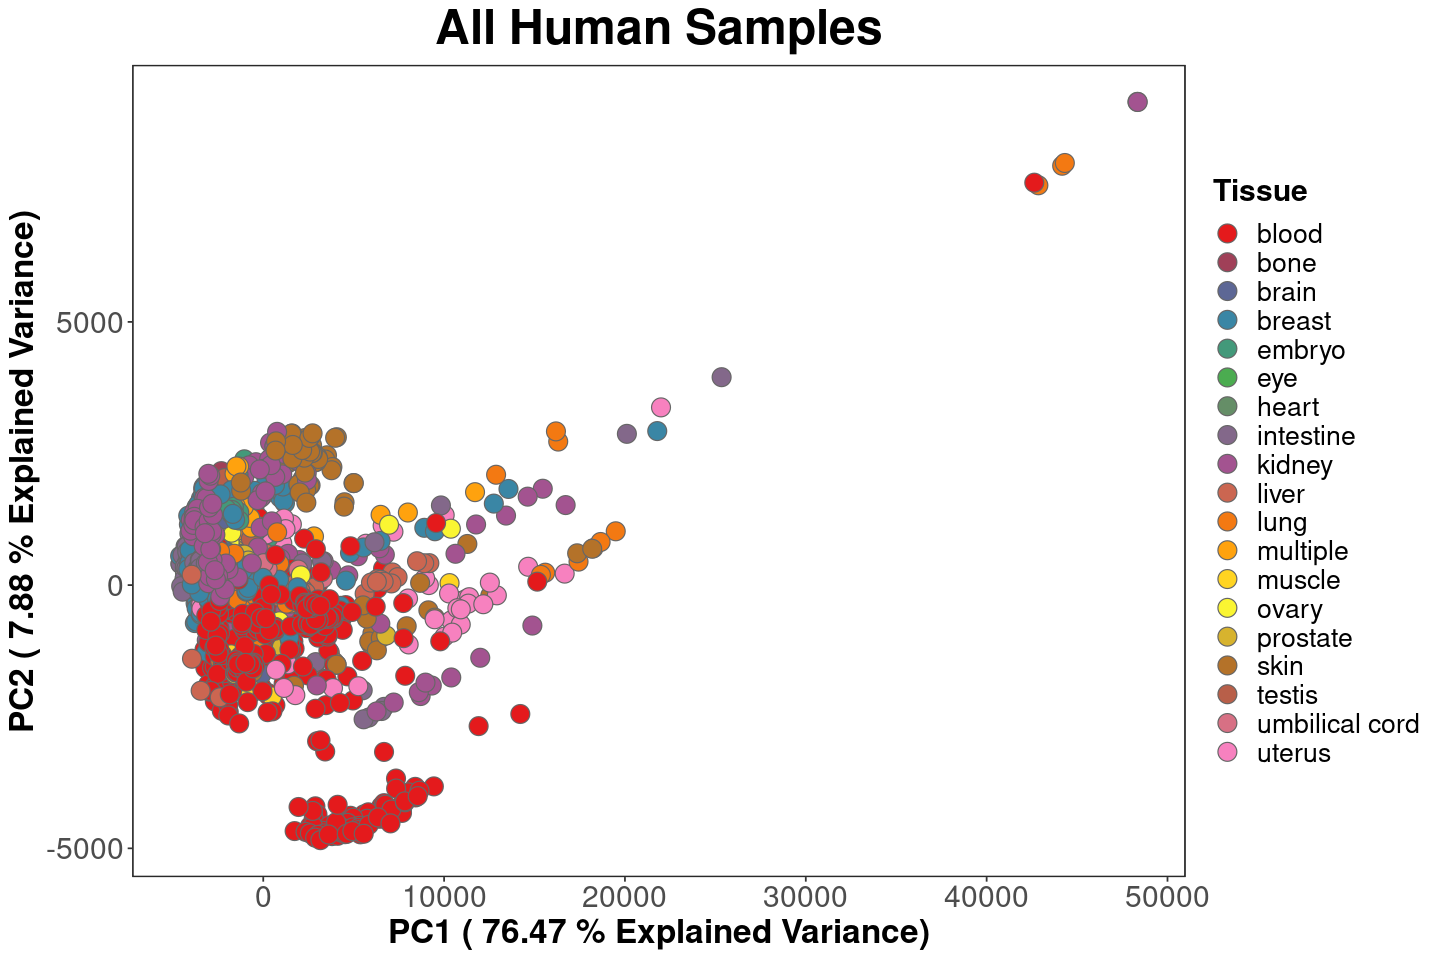

In [48]:
options(repr.plot.width=12, repr.plot.height=8)
pc1n2_all <- gg_pca_palette(pc_tpms_metadata, pc_tpms_metadata$PC1,
       pc_tpms_metadata$PC2, pc_tpms_metadata$tissue,mycolors2,
      "All Human Samples", paste("PC1 (",as.character(pc1),"% Explained Variance)"),
              paste("PC2 (",as.character(pc2),"% Explained Variance)"), "Tissue")
pc1n2_all

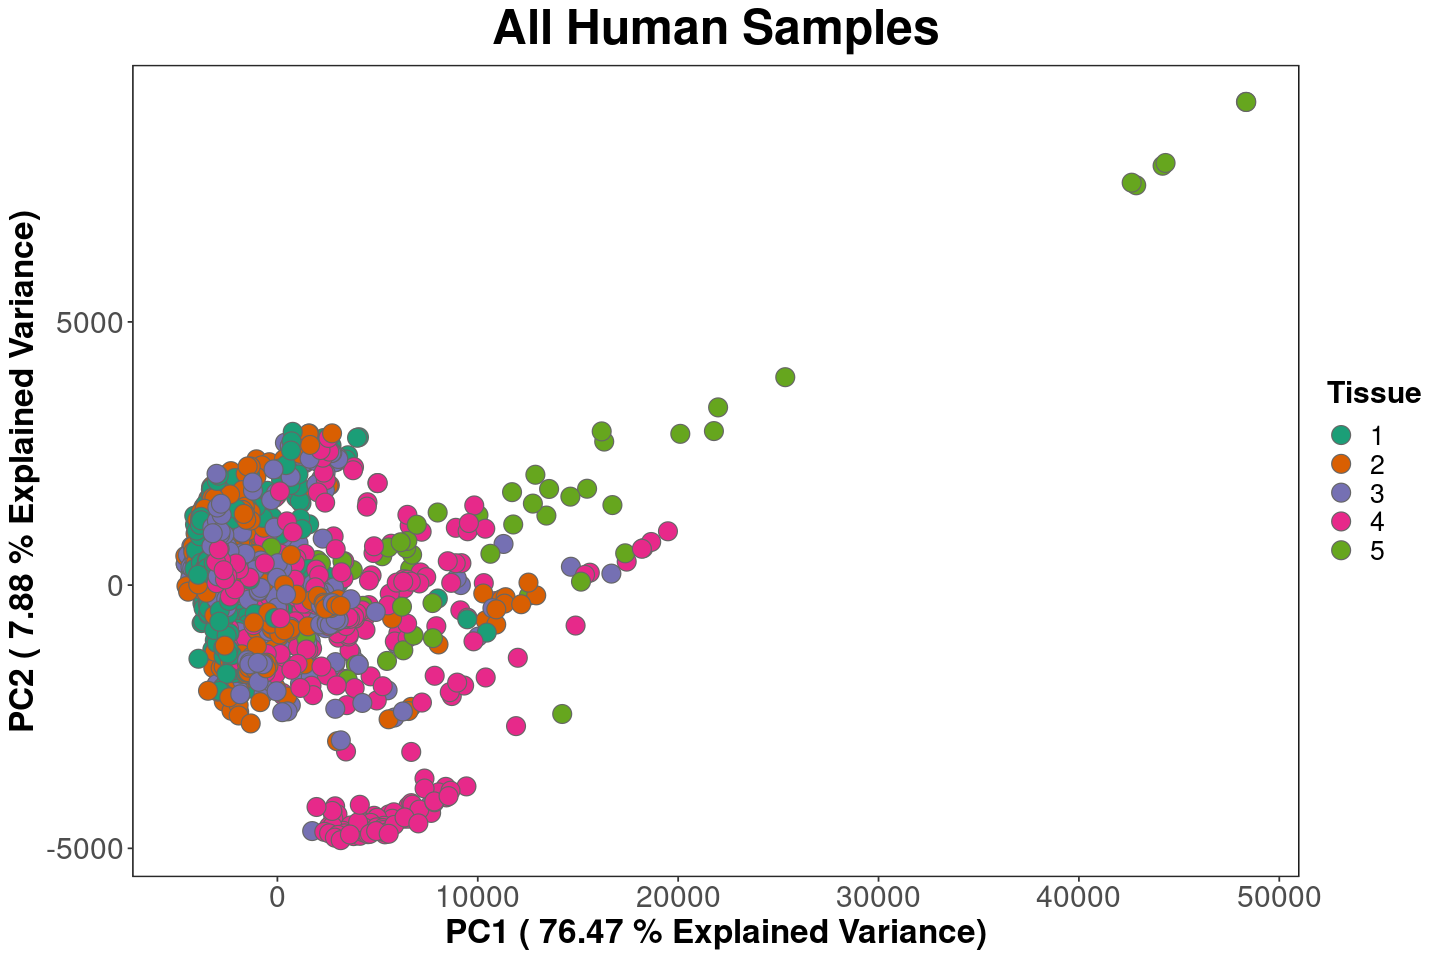

In [50]:
options(repr.plot.width=12, repr.plot.height=8)
pc1n2_all_qc <- gg_pca(pc_tpms_metadata, pc_tpms_metadata$PC1,
       pc_tpms_metadata$PC2, as.factor(pc_tpms_metadata$samp_qc_score),"Dark2",
      "All Human Samples", paste("PC1 (",as.character(pc1),"% Explained Variance)"),
              paste("PC2 (",as.character(pc2),"% Explained Variance)"), "Tissue")
pc1n2_all_qc

### Filtered samples

In [51]:
##1. get all genes
gene_tpm_filtered <- gene_all_bidir_tpm_filtered[gene_all_bidir_tpm_filtered$gene_transcript %in% 
                                 counts_genes$gene_transcript,]

##2. filter genes with transcription
gene_tpm_df_transcribed <- subset(gene_all_bidir_tpm_filtered_summary, max >=5)
gene_tpm_transcribed_filtered <- gene_tpm_filtered[gene_tpm_filtered$gene_transcript %in% 
                                       gene_tpm_df_transcribed$gene_transcript, ]

##3. run PCA
pca_genes_filtered <- pca_counts(gene_tpm_transcribed_filtered, 
                                 ncol(gene_tpm_transcribed_filtered))

[1] "Principal Component :  1"
[1] "Explained variance =  43.41"
[1] "Principal Component :  2"
[1] "Explained variance =  14.71"
[1] "Principal Component :  3"
[1] "Explained variance =  8.78"
[1] "Principal Component :  4"
[1] "Explained variance =  4.29"


In [52]:
pc1filt <- "43.41"
pc2filt <- "14.71"
pc3filt <- "8.78"
pc4filt <- "4.29"

In [53]:
#combine PCs with metadata
pc_tpms_metadata_filtered <- merge(pca_genes_filtered, 
                          metadata, 
                         by = 'sample_name')
dim(pc_tpms_metadata_filtered)
head(pc_tpms_metadata_filtered, 3)

[1] 751  18

,sample_name,PC1,PC2,PC3,PC4,organism,tissue,tissue_description,disease,srp,paper_id,protocol,sample_type,cell_type,samp_qc_score,samp_data_score,replicate,control_experimental
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
1,ERR769524,-1230.6418,766.1281,533.1474,123.5659,H. sapiens,uterus,uterus; cervix; cervical adenocarcinoma,1,ERP009673,Laitem2015cdk9,GRO-seq,cell line,HeLa,2,1,1,control
2,ERR769525,-1273.3125,760.7996,467.7503,161.5393,H. sapiens,uterus,uterus; cervix; cervical adenocarcinoma,1,ERP009673,Laitem2015cdk9,GRO-seq,cell line,HeLa,2,1,2,control
3,SRM497907,913.3851,763.1250,-531.2817,154.2492,H. sapiens,breast,breast; mammary; adenocarcinoma,1,SRP018256,Hah2013enhancer,GRO-seq,cell line,MCF7,2,2,2,control


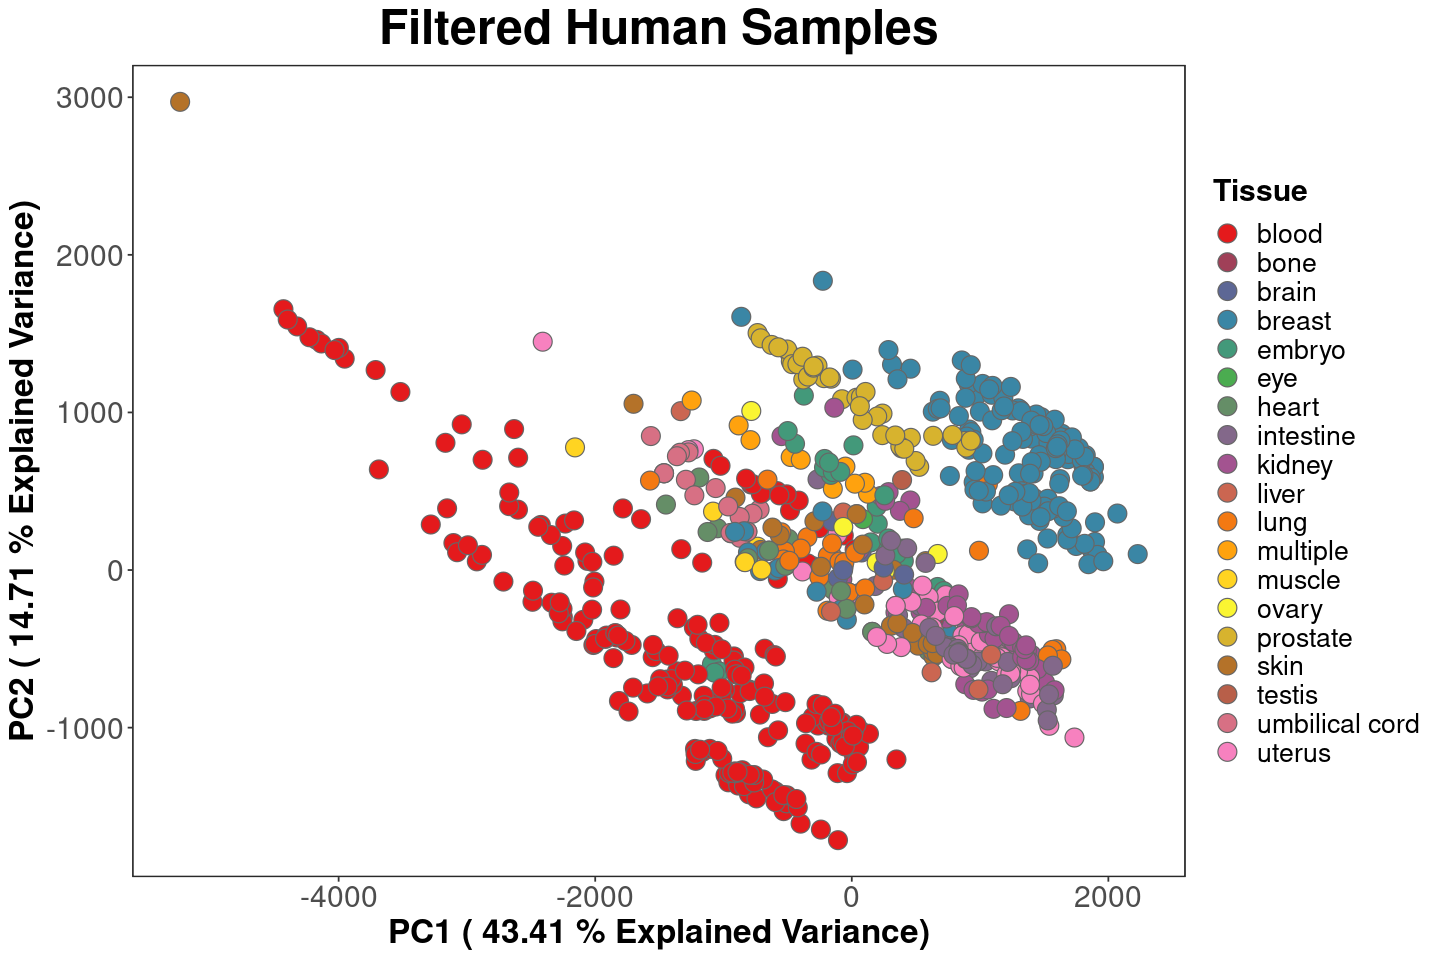

In [54]:
options(repr.plot.width=12, repr.plot.height=8)
pc1n2_filtered <- gg_pca_palette(pc_tpms_metadata_filtered, pc_tpms_metadata_filtered$PC1,
       pc_tpms_metadata_filtered$PC2, pc_tpms_metadata_filtered$tissue,mycolors2,
      "Filtered Human Samples", paste("PC1 (",as.character(pc1filt),"% Explained Variance)"),
              paste("PC2 (",as.character(pc2filt),"% Explained Variance)"), "Tissue")

pc1n2_filtered

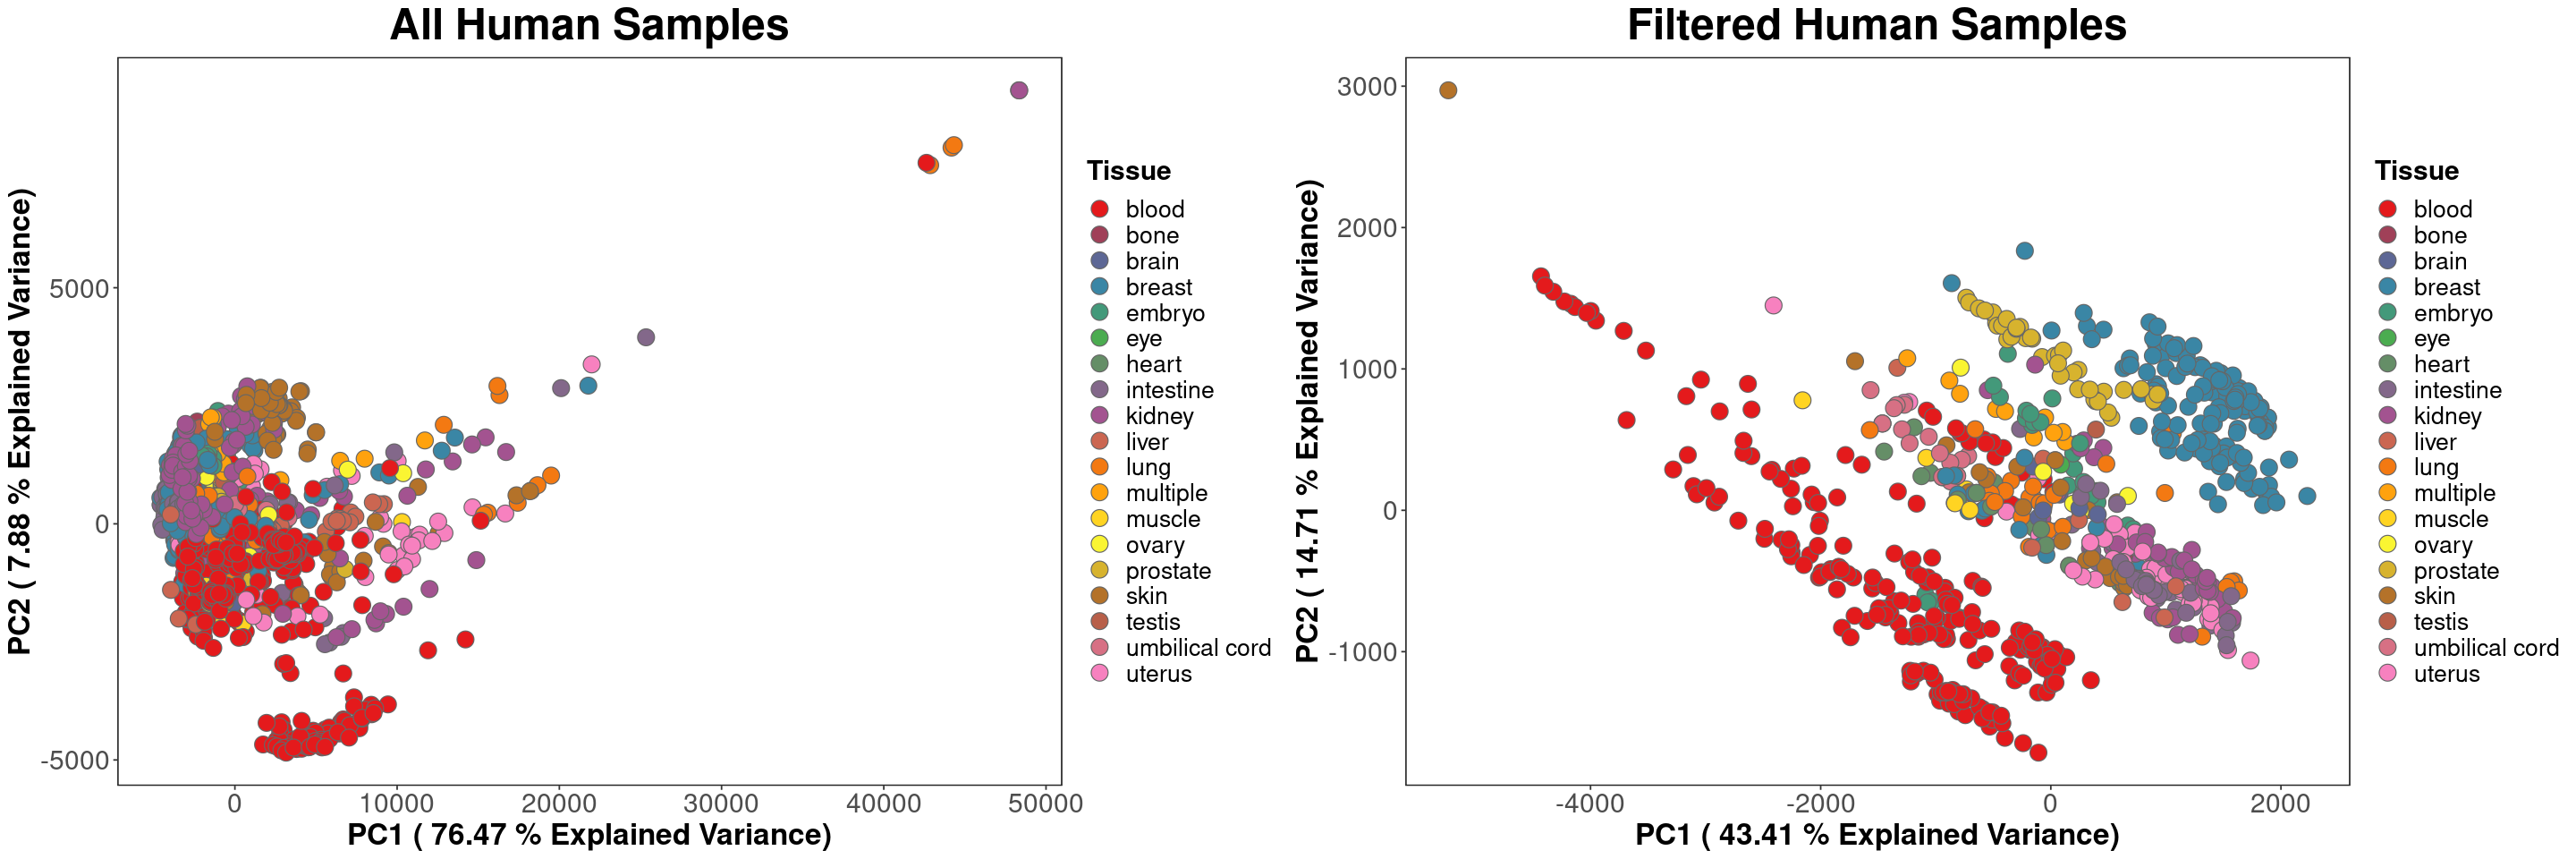

In [55]:
options(repr.plot.width=24, repr.plot.height=8)
cowplot::plot_grid(pc1n2_all, pc1n2_filtered)

# Session Information

In [56]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-3 tidyr_1.2.1        dplyr_1.0.10       data.table_1.14.2 
[5] cowplot_1.1.1      ggplot2_3.3.6     

loaded via a namespace (and not attached):
 [1] pillar_1.8.1     compiler_3.6.0   base64enc_0.1-3  tools_3.6.0     
 [5] digest_0.6.29    uuid_1.1-0       jsonlite_1.8.0   evaluate_0.16   
 [9] lifecycle_1.0.3  t